In [ ]:
#use mount instead if faster?
import io
import pandas as pd
from google.colab import files
!rm *.xlsx
uploaded = files.upload()

rm: cannot remove '*.xlsx': No such file or directory


Saving Cbasil_PHB_1G.xlsx to Cbasil_PHB_1G.xlsx
Saving Cbasil_PHB_LSMMG.xlsx to Cbasil_PHB_LSMMG.xlsx
Saving Ecoli_BC_1G.xlsx to Ecoli_BC_1G.xlsx
Saving Ecoli_BC_LSMMG.xlsx to Ecoli_BC_LSMMG.xlsx
Saving Ecoli_EYFP_1G.xlsx to Ecoli_EYFP_1G.xlsx
Saving Ecoli_EYFP_LSMMG.xlsx to Ecoli_EYFP_LSMMG.xlsx
Saving Ppas_BC_1G.xlsx to Ppas_BC_1G.xlsx
Saving Ppas_BC_LSMMG.xlsx to Ppas_BC_LSMMG.xlsx
Saving Ppas_BC_LUNAR.xlsx to Ppas_BC_LUNAR.xlsx
Saving Ppas_BC_MARTIAN.xlsx to Ppas_BC_MARTIAN.xlsx
Saving Ppas_Wild_1G.xlsx to Ppas_Wild_1G.xlsx
Saving Ppas_Wild_LSMMG.xlsx to Ppas_Wild_LSMMG.xlsx
Saving Ppas_Wild_LUNAR.xlsx to Ppas_Wild_LUNAR.xlsx
Saving Ppas_Wild_MARTIAN.xlsx to Ppas_Wild_MARTIAN.xlsx
Saving Pput_Wild_1G.xlsx to Pput_Wild_1G.xlsx
Saving Pput_Wild_LSMMG.xlsx to Pput_Wild_LSMMG.xlsx
Saving Scere_BC_1G.xlsx to Scere_BC_1G.xlsx
Saving Scere_BC_LSMMG.xlsx to Scere_BC_LSMMG.xlsx
Saving Scere_BC_LUNAR.xlsx to Scere_BC_LUNAR.xlsx
Saving Scere_BC_MARTIAN.xlsx to Scere_BC_MARTIAN.xlsx
Saving Sce

In [ ]:
import torch
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [ ]:
organism_list = []
substance_list = []
gravity_list = []
obj_list = []

class Preprocess:
  def __init__(self, file_name):
    self.file_name = file_name
    self.organism, self.substance, self.gravity = self.file_name.split(".")[0].split()[0].split("_")
    self.update_list(organism_list, self.organism)
    self.update_list(substance_list, self.substance)
    self.update_list(gravity_list, self.gravity)

  def update_list(self, item_list, item):
    #if item not in item_list:
    item_list.append(item)

In [ ]:
for file_name in uploaded.keys():
  obj = Preprocess(file_name)
  obj_list.append(obj)

In [ ]:
from sklearn.preprocessing import LabelEncoder

organism_encode = LabelEncoder()
substance_encode = LabelEncoder()
gravity_encode = LabelEncoder()

organism_label = organism_encode.fit_transform(organism_list)
substance_label = substance_encode.fit_transform(substance_list)
gravity_label = gravity_encode.fit_transform(gravity_list)

In [ ]:
import numpy as np

data_list = []

class Data:
  def __init__(self,file_name, organism, substance, gravity):
    self.file_name = file_name
    self.organism = organism
    self.substance = substance
    self.gravity = gravity
    self.growth_time, self.growth_val = self.assign_data()
    self.growth_input_np = self.create_inputs(self.growth_time, self.growth_val)
    self.growth_val_np = self.growth_val.reshape(-1, 1)

  def assign_data(self):
    growth_df = pd.read_excel(self.file_name, sheet_name = 0).iloc[1:]
    growth_time = growth_df.iloc[:,:1].to_numpy()
    growth_df_transpose = growth_df.iloc[:,1:].T
    growth_df_transpose.fillna(growth_df_transpose.mean(), inplace = True)
    growth_val = growth_df_transpose.T.to_numpy()

    return growth_time, growth_val

  def create_inputs(self, input, output):
    """
    Returns inputs in order of organism, substance, gravity, and time
    """
    input_length = len(input)
    output_length = len(output[0])

    input_stacked = np.tile(input, output_length).reshape(-1, 1)

    categorical_inputs = [self.organism, self.substance, self.gravity]
    categorical_inputs_stacked = np.tile(categorical_inputs, input_length * output_length).reshape(-1, len(categorical_inputs))

    return np.hstack((categorical_inputs_stacked, input_stacked)).astype(float)

In [ ]:
for i, obj in enumerate(obj_list):
  data_obj = Data(obj.file_name, organism_label[i], substance_label[i], gravity_label[i])
  data_list.append(data_obj)

In [ ]:
#aggregate inputs and outputs
growth_input = data_list[0].growth_input_np
#titer_input = data_list[0].titer_input_np
growth_output = data_list[0].growth_val_np
#titer_output = data_list[0].titer_val_np

for i in range(1, len(data_list)):
  growth_input = np.vstack((growth_input, data_list[i].growth_input_np))
  growth_output = np.vstack((growth_output, data_list[i].growth_val_np))

#Standardize Time

In [ ]:
#standardize time
growth_time_input_mean = np.mean(growth_input[:, 3])
growth_time_input_std_dev = np.std(growth_input[:, 3])
growth_input[:,3] = (growth_input[:, 3] - growth_time_input_mean)/growth_time_input_std_dev

In [ ]:
#train test split
from sklearn.model_selection import train_test_split

#80% train, 10% validation, 10% test
growth_input_train, growth_input_test_val, growth_output_train, growth_output_test_val = train_test_split(growth_input, growth_output, test_size = 0.2, random_state = 42)
growth_input_val, growth_input_test, growth_output_val, growth_output_test = train_test_split(growth_input_test_val, growth_output_test_val, test_size = 0.5, random_state = 42)

In [ ]:
growth_input_train_tensor = torch.tensor(growth_input_train, device=device)
growth_input_test_tensor = torch.tensor(growth_input_test,device=device)
growth_output_train_tensor = torch.tensor(growth_output_train,device=device)
growth_output_test_tensor = torch.tensor(growth_output_test,device=device)
growth_input_val_tensor = torch.tensor(growth_input_val, device=device)
growth_output_val_tensor = torch.tensor(growth_output_val, device=device)

#Train network

In [ ]:
from torch import nn
import torch.nn.functional as F

In [ ]:
class Net_5(nn.Module):
    def __init__(self, nodes):
        super(Net_5,self).__init__()
        self.fc1 = nn.Linear(4, nodes)
        self.fc2 = nn.Linear(nodes, nodes)
        self.fc3 = nn.Linear(nodes, nodes)
        self.fc4 = nn.Linear(nodes, nodes)
        self.fc5 = nn.Linear(nodes, 1)
        self.double()

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [ ]:
import torch.optim as optim

learning_rate = 0.01
iter = 10000
nodes = 50
net = Net_5(nodes).to(device)

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

for i in range(iter):
  # in your training loop:
  optimizer.zero_grad()   # zero the gradient buffers
  output = net(growth_input_train_tensor)
  loss = criterion(output, growth_output_train_tensor)
  loss.backward()
  optimizer.step()

In [ ]:
test_point = growth_input_train_tensor[100]
print(test_point)
print(net(test_point))

tensor([6.0000, 3.0000, 2.0000, 2.7570], dtype=torch.float64)
tensor([3.8792], dtype=torch.float64, grad_fn=<ViewBackward0>)


#Predictions

In [ ]:
from torch import Tensor
def prediction(categorical_inputs, min_time, max_time):
  time_linspace_tensor = torch.linspace(min_time, max_time, 1000, dtype = torch.double).reshape(-1,1)

  organism_point_transform = torch.tensor(organism_encode.transform([categorical_inputs[0]])).reshape(-1,1)
  substance_point_transform = torch.tensor(substance_encode.transform([categorical_inputs[1]])).reshape(-1,1)
  gravity_point_transform = torch.tensor(gravity_encode.transform([categorical_inputs[2]])).reshape(-1,1)

  categorical_inputs_transformed = torch.tensor([organism_point_transform, substance_point_transform, gravity_point_transform]).squeeze()

  categorical_inputs_transformed_stacked = Tensor.repeat(categorical_inputs_transformed, len(time_linspace_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_linspace_tensor))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output = net(input_standardized)
  return time_linspace_tensor.numpy(), predicted_output.detach().numpy()

In [ ]:
def prediction_2(categorical_inputs, min_time, max_time):
  time_linspace_tensor = torch.linspace(min_time, max_time, 1000, dtype = torch.double).reshape(-1,1)
  categorical_inputs_transformed = torch.tensor([categorical_inputs]).squeeze()
  categorical_inputs_transformed_stacked = Tensor.repeat(categorical_inputs_transformed, len(time_linspace_tensor)).reshape(-1, len(categorical_inputs))

  input_unstandardized = torch.hstack((categorical_inputs_transformed_stacked, time_linspace_tensor))
  input_unstandardized[:,3] = (input_unstandardized[:,3] - growth_time_input_mean) / growth_time_input_std_dev

  input_standardized = input_unstandardized
  predicted_output = net(input_standardized)
  return time_linspace_tensor.numpy(), predicted_output.detach().numpy()

#Plots

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#removed dataset for plotting later
time_removed = [0, 4, 8, 12, 16, 24]
growth_removed = [0.025, 1.57, 2.97, 3.47, 4.9, 5.43]
growth_seen = [0.03, 0.83, 3.33, 3.78, 4.88, 4.84]

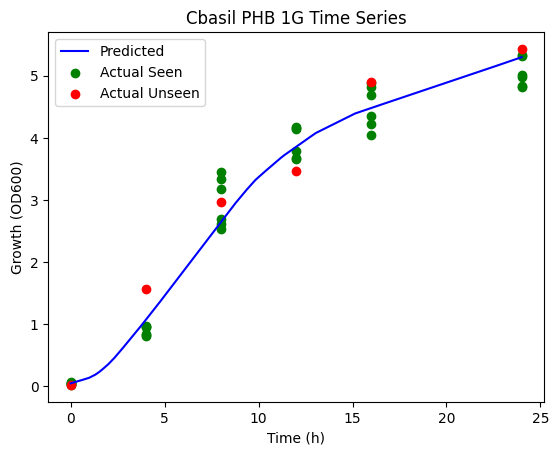

In [ ]:
categorical_inputs = ["Cbasil", "PHB", "1G"]

time, output = prediction(categorical_inputs, time_removed[0], time_removed[-1])

plt.plot(time, output, color = "b", label = "Predicted")
plt.title(f"{categorical_inputs[0]} {categorical_inputs[1]} {categorical_inputs[2]} Time Series")
plt.xlabel("Time (h)")
plt.ylabel("Growth (OD600)")

for i in range(len(data_list[0].growth_val[:])):
  time = data_list[0].growth_time
  growth_seen = data_list[0].growth_val[:,i]
  plt.scatter(time, growth_seen, color = 'g', label = "Actual Seen" if i == 0 else "")

plt.scatter(time_removed, growth_removed, color = "r", label = "Actual Unseen")
plt.legend()
plt.show()

In [ ]:
data_list[2].organism

1

In [ ]:
data_list_2_time, data_list_2_output = prediction_2([data_list[2].organism, data_list[2].substance, data_list[2].gravity], data_list[2].growth_time[0,0], data_list[2].growth_time[-1,0])
data_list_3_time, data_list_3_output = prediction_2([data_list[3].organism, data_list[3].substance, data_list[3].gravity], data_list[3].growth_time[0,0], data_list[3].growth_time[-1,0])

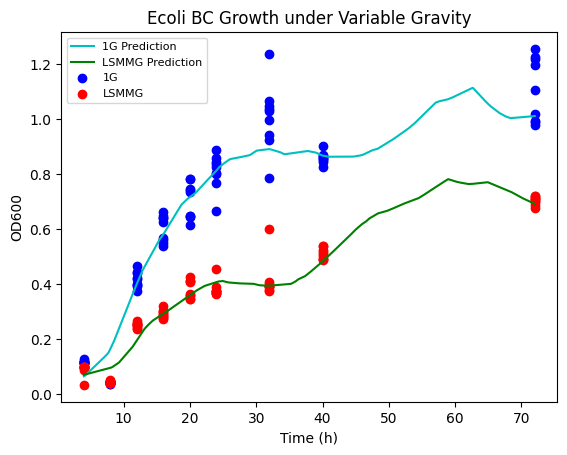

In [ ]:
plt.title(f"{organism_encode.inverse_transform([data_list[2].organism])[0]} {substance_encode.inverse_transform([data_list[2].substance])[0]} Growth under Variable Gravity")

#plot predictions
plt.plot(data_list_2_time, data_list_2_output, color = 'c', label = f"{gravity_encode.inverse_transform([data_list[2].gravity])[0]} Prediction")
plt.plot(data_list_3_time, data_list_3_output, color= 'g', label = f"{gravity_encode.inverse_transform([data_list[3].gravity])[0]} Prediction")

for i in range(len(data_list[2].growth_val[:])):
  plt.scatter(data_list[2].growth_time, data_list[2].growth_val[:,i], color = 'b', label = f"{gravity_encode.inverse_transform([data_list[2].gravity])[0]}" if i == 0 else "")
for j in range(len(data_list[3].growth_val[:])):
  plt.scatter(data_list[3].growth_time, data_list[3].growth_val[:,j], color = 'r', label = f"{gravity_encode.inverse_transform([data_list[3].gravity])[0]}" if j == 0 else "")

plt.xlabel("Time (h)")
plt.ylabel("OD600")
plt.legend(fontsize = "8")
plt.show()

In [ ]:
def plot_growth(data_list):

  #generate predictions
  for data in data_list:
    data_list_time, data_list_output = prediction_2(
        [data.organism, data.substance, data.gravity],
        data.growth_time[0,0],
        data.growth_time[-1,0]
        )
    #plot predictions
    plt.plot(data_list_time, data_list_output, label=f"{gravity_encode.inverse_transform([data.gravity])[0]} Prediction")

    #stack the growth_time into one np array
    growth_time = np.empty(0)
    for i in range(len(data.growth_time)):
      temp = np.full(len(data.growth_val[0]), data.growth_time[i])
      growth_time = np.concatenate((growth_time, temp))
    #stack the growth_val into one np array
    growth_val = data.growth_val.reshape(-1, 1)
    #plot real data
    plt.scatter(growth_time, growth_val, label = f"{gravity_encode.inverse_transform([data.gravity])[0]}" if i == 0 else "")

  #only take the first object's name for generating the plot title
  plt.title(f"{organism_encode.inverse_transform([data_list[0].organism])[0]} {substance_encode.inverse_transform([data_list[0].substance])[0]} Growth under Variable Gravity")
  plt.xlabel("Time (h)")
  plt.ylabel("OD600")
  plt.legend(fontsize = "8")
  plt.show()

In [ ]:
for i in range(len(data_list)):
  print(i, data_list[i].file_name)

0 Cbasil_PHB_1G.xlsx
1 Cbasil_PHB_LSMMG.xlsx
2 Ecoli_BC_1G.xlsx
3 Ecoli_BC_LSMMG.xlsx
4 Ecoli_EYFP_1G.xlsx
5 Ecoli_EYFP_LSMMG.xlsx
6 Ppas_BC_1G.xlsx
7 Ppas_BC_LSMMG.xlsx
8 Ppas_BC_LUNAR.xlsx
9 Ppas_BC_MARTIAN.xlsx
10 Ppas_Wild_1G.xlsx
11 Ppas_Wild_LSMMG.xlsx
12 Ppas_Wild_LUNAR.xlsx
13 Ppas_Wild_MARTIAN.xlsx
14 Pput_Wild_1G.xlsx
15 Pput_Wild_LSMMG.xlsx
16 Scere_BC_1G.xlsx
17 Scere_BC_LSMMG.xlsx
18 Scere_BC_LUNAR.xlsx
19 Scere_BC_MARTIAN.xlsx
20 Scere_Wild_1G.xlsx
21 Scere_Wild_LSMMG.xlsx
22 Scere_Wild_LUNAR.xlsx
23 Scere_Wild_MARTIAN.xlsx
24 Vnat_Wild_1G.xlsx
25 Vnat_Wild_LSMMG.xlsx
26 Ylipo_BC_1G.xlsx
27 Ylipo_BC_LSMMG.xlsx
28 Ylipo_BC_LUNAR.xlsx
29 Ylipo_BC_MARTIAN.xlsx
30 Ylipo_Wild_1G.xlsx
31 Ylipo_Wild_LSMMG.xlsx
32 Ylipo_Wild_LUNAR.xlsx
33 Ylipo_Wild_MARTIAN.xlsx


#visualize list of objects

In [ ]:
print(data_list)

[<__main__.Data object at 0x7dad3a4d7b20>, <__main__.Data object at 0x7dad3a4ca080>, <__main__.Data object at 0x7dad3a4d6e00>, <__main__.Data object at 0x7dad3a4d7910>, <__main__.Data object at 0x7dad3a4d7430>, <__main__.Data object at 0x7dad3a4d7a60>, <__main__.Data object at 0x7dad3969dd50>, <__main__.Data object at 0x7dad3a4cb3a0>, <__main__.Data object at 0x7dad3983baf0>, <__main__.Data object at 0x7dad3983bd60>, <__main__.Data object at 0x7dad3a24ba90>, <__main__.Data object at 0x7dad3a4cb220>, <__main__.Data object at 0x7dad3a4c8580>, <__main__.Data object at 0x7dad3a29c2e0>, <__main__.Data object at 0x7dad3a29de40>, <__main__.Data object at 0x7dad3a4d7a00>, <__main__.Data object at 0x7dad3a7b3190>, <__main__.Data object at 0x7dad3987fd00>, <__main__.Data object at 0x7dad3969f310>, <__main__.Data object at 0x7dad3969d3c0>, <__main__.Data object at 0x7dad3969ead0>, <__main__.Data object at 0x7dad3969dba0>, <__main__.Data object at 0x7dad396d89d0>, <__main__.Data object at 0x7dad39

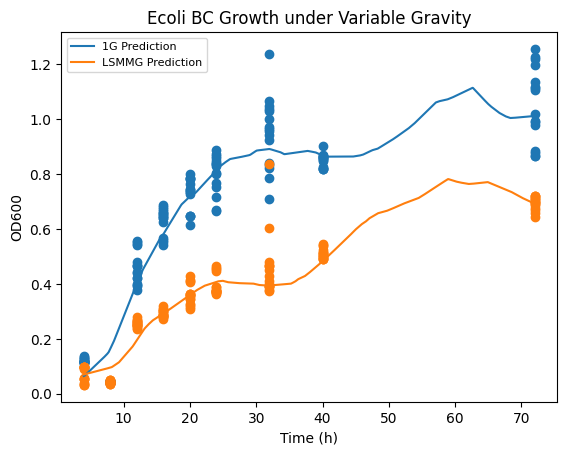

In [ ]:
#Ecoli BC Growth
plot_growth([data_list[2], data_list[3]])

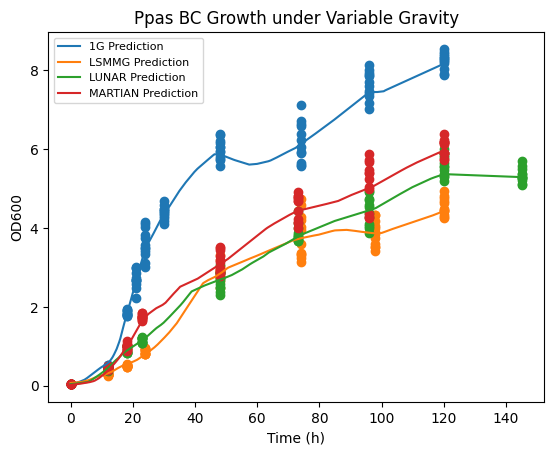

In [ ]:
#Scere BC Growth
plot_growth([data_list[6], data_list[7], data_list[8], data_list[9]])

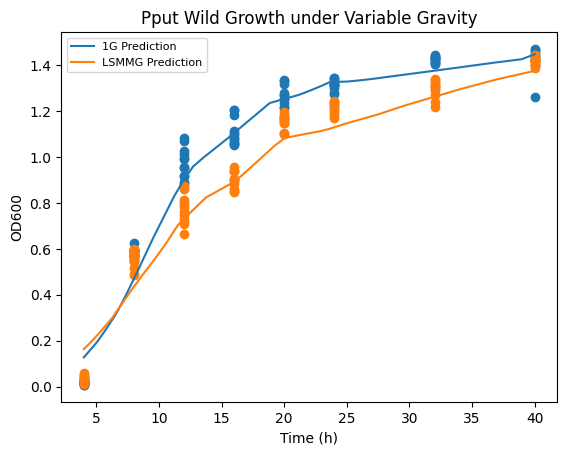

In [ ]:
#Pput Wild Growth
plot_growth([data_list[14], data_list[15]])

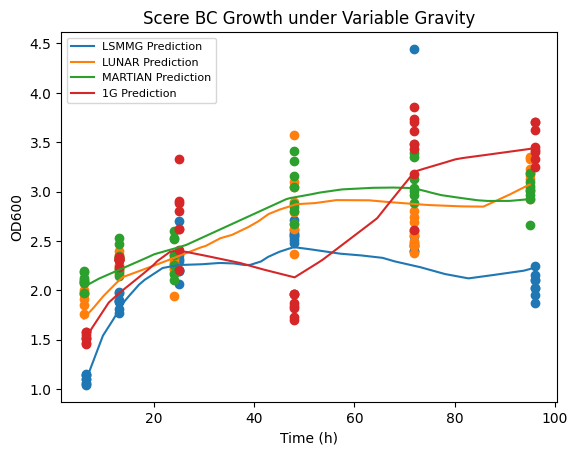

In [ ]:
#Vnat wild growth
plot_growth([data_list[17], data_list[18], data_list[19], data_list[20]])